In [1]:
from __future__ import annotations

import dataclasses
import json
import pathlib
import threading
import time

import const
import cv2
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import tqdm
import utils

In [2]:
def to_displayable(img, converted: int | None = cv2.COLOR_BGR2RGB) -> PIL.Image.Image:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    return PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255))


def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    display(to_displayable(img, converted))

In [3]:
vid = "sun2"
rec_frames, _ = utils.read_video(const.VIDEOS_DIR / "debug-match.mp4")
src_frames, src_ts = utils.read_video(const.VIDEOS_DIR / f"{vid}.mp4")
src_frames = utils.crop_to_size(src_frames, 640, 480)

Reading c:\Extra\Masters\event-sun-effects-remover\experiments\videos\debug-match.mp4:   0%|          | 0/60 [00:00<?, ?it/s]

Reading c:\Extra\Masters\event-sun-effects-remover\experiments\videos\debug-match.mp4: 100%|██████████| 60/60 [00:00<00:00, 1764.72it/s]
Reading c:\Extra\Masters\event-sun-effects-remover\experiments\videos\sun2.mp4: 100%|██████████| 1744/1744 [00:05<00:00, 299.17it/s]


In [4]:
align_meta = json.loads((const.META_DIR / f"match-{vid}.json").read_text())
ts_offset = align_meta["temporal_offset"]

In [5]:
homographies = np.array(align_meta["homographies"])
debug_masks = utils.make_horiz_masks(len(homographies), 640, 480)

In [6]:
window_length = 50
ref_frame_idx = 5
best_rec_idx = (ts_offset + src_ts[ref_frame_idx]) // window_length

In [7]:
ref_gs = cv2.cvtColor(src_frames[ref_frame_idx], cv2.COLOR_BGR2GRAY)
rec_best_gs = cv2.cvtColor(rec_frames[best_rec_idx], cv2.COLOR_BGR2GRAY)

# sharepen rec_best_gs
rec_best_gs_gb = cv2.GaussianBlur(rec_best_gs, (0, 0), 3)
rec_best_gs = cv2.addWeighted(rec_best_gs, 1.5, rec_best_gs_gb, -0.5, 0)

In [8]:
ref_mx = src_frames[ref_frame_idx].min(axis=2)
pure_white_mask = ref_mx == 255

pure_eroded = cv2.erode(
    pure_white_mask.astype(np.uint8), np.ones((5, 5), np.uint8), iterations=2
)

ToggleButton(value=True, button_style='danger', description='Stop', icon='square', tooltip='Click Me!')

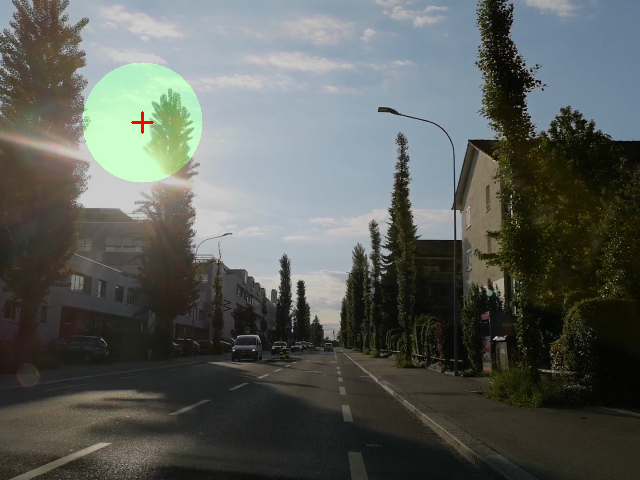

In [9]:
def view(button: ipywidgets.ToggleButton) -> None:
    display_handle = display(None, display_id=True)
    i = 0
    largest_contour_center = (0, 0)
    while button.value:
        if i >= len(src_frames):
            i = 0
        i += 1
        src_frame = src_frames[i].copy()
        src_frame_min_color = src_frame.min(axis=2)
        pure_white_mask = src_frame_min_color >= 230
        pure_eroded = cv2.erode(
            pure_white_mask.astype(np.uint8), np.ones((5, 5), np.uint8), iterations=2
        )
        pure_eroded_contours, _ = cv2.findContours(
            pure_eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        pure_eroded_contours = sorted(
            pure_eroded_contours, key=cv2.contourArea, reverse=True
        )
        if pure_eroded_contours:
            largest_contour = pure_eroded_contours[0]
            largest_contour_center = np.mean(largest_contour, axis=0).astype(int)[0]

        circle_mask = np.zeros_like(src_frame)
        cv2.circle(
            circle_mask,
            tuple(largest_contour_center),
            60,
            (0, 255, 0),
            -1,
        )
        src_frame = cv2.addWeighted(src_frame, 0.8, circle_mask, 0.2, 0)
        cv2.drawMarker(
            src_frame,
            tuple(largest_contour_center),
            (0, 0, 255),
            markerType=cv2.MARKER_CROSS,
            markerSize=20,
            thickness=2,
        )
        disp = to_displayable(src_frame)
        display_handle.update(disp)
        time.sleep(0.1)


button = ipywidgets.ToggleButton(
    description="Stop",
    value=True,
    disabled=False,
    button_style="danger",
    tooltip="Click Me!",
    icon="square",
)

# showarray(src_frames[ref_frame_idx])
display(button)
threading.Thread(target=view, args=(button,)).start()

In [10]:
@dataclasses.dataclass
class AlignMeta:
    homographies: np.ndarray
    offset_ms: int

    @classmethod
    def from_json(cls, path: pathlib.Path) -> AlignMeta:
        data = json.loads(path.read_text())
        homographies = np.array(data["homographies"])
        assert len(homographies.shape) == 3, "There should be a list of homographies"
        assert (
            homographies.shape[1] == 3 and homographies.shape[2] == 3
        ), "Invalid shape"
        offset_ms = data["temporal_offset"]
        return cls(homographies, offset_ms)

    def get_common_mask(self, width: int, height: int) -> np.ndarray:
        common_mask = np.zeros((height, width), np.uint8)
        masks = utils.make_horiz_masks(len(self.homographies), width, height)
        for mask, hom in zip(masks, self.homographies):
            full_img = np.ones((height, width), np.uint8) * 255
            full_img = cv2.warpPerspective(full_img, hom, (width, height))
            common_mask[mask > 0] = full_img[mask > 0]
        return common_mask

In [11]:
import rpg_e2vid.utils.inference_utils as iu
import rpg_e2vid.utils.loading_utils as lu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lu.load_model(const.PRETRAINED_DIR / "E2VID_lightweight.pth.tar").to(device)
events = utils.EventsData.from_path("./parsed/sun2.bin")
_, ts_counts = np.unique(events.array[:, 0], return_counts=True)
am = AlignMeta.from_json(const.META_DIR / "match-sun2.json")

c:\Users\njytwf\AppData\Local\anaconda3\envs\masters\lib\site-packages\rpg_e2vid\utils\loading_utils.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_model = torch.lo

Using TransposedConvLayer (fast, with checkerboard artefacts)


In [13]:
skip_events = ts_counts[: am.offset_ms].sum()
events_arr = events.array[skip_events:]
ts_counts = ts_counts[am.offset_ms :]

In [14]:
count_idx = 0
event_idx = 0
reconstructed = []
prev = None
masks = utils.make_horiz_masks(len(am.homographies), events.width, events.height)
hom_mask = am.get_common_mask(events.width, events.height) > 0
for i in tqdm.tqdm(range(1, src_frames.shape[0])):
    if src_ts[i] == 0:
        continue
    window_start = src_ts[i - 1]
    window_end = src_ts[i]
    events_in_window = ts_counts[window_start:window_end].sum()
    events_end = event_idx + events_in_window
    window = events_arr[event_idx:events_end]
    if not window.size or np.isnan(window).any():
        continue
    count_idx += src_ts[i]
    event_idx = events_end
    vg = iu.events_to_voxel_grid(window, 5, events.width, events.height)
    vg = torch.from_numpy(vg).to(device).unsqueeze(0).float()
    with torch.no_grad():
        pred, prev = model(vg, prev)
        pred = (pred.squeeze().cpu().numpy() * 255).astype(np.uint8)

    pred = cv2.undistort(pred, const.EVENT_MTX, const.EVENT_DIST)
    combined = np.zeros_like(pred)
    for mask, hom in zip(masks, am.homographies):
        warped = cv2.warpPerspective(pred.copy(), hom, (events.width, events.height))
        combined[mask > 0] = warped[mask > 0]

    reconstructed.append(combined)
reconstructed = np.array(reconstructed)

100%|██████████| 1743/1743 [02:02<00:00, 14.19it/s]


In [31]:
out = cv2.VideoWriter(
    "sun2-combined-gs.mp4", cv2.VideoWriter_fourcc(*"mp4v"), 30, (640 * 2, 480)
)
for idx in tqdm.tqdm(range(len(reconstructed))):
    src_frame_gs = cv2.cvtColor(src_frames[idx], cv2.COLOR_BGR2GRAY)
    rec_frame = reconstructed[idx]
    rec_frame_bgr = cv2.cvtColor(rec_frame, cv2.COLOR_GRAY2BGR)

    diff_frame = (cv2.absdiff(src_frame_gs, rec_frame) > 75).astype(np.uint8) * 255
    diff_frame[~hom_mask] = 0
    eroded = cv2.erode(diff_frame, np.ones((5, 5), np.uint8), iterations=4)
    dilated = cv2.dilate(eroded, np.ones((5, 5), np.uint8), iterations=16)
    dilated[~hom_mask] = 0
    combined = src_frames[idx].copy()
    combined[dilated > 0] = rec_frame_bgr[dilated > 0]
    concat = np.concatenate([src_frames[idx], combined], axis=1)
    out.write(concat)

out.release()

100%|██████████| 1693/1693 [00:11<00:00, 150.30it/s]


In [309]:
def make_horiz_masks(n: int, width: int, height: int) -> dict[str, np.ndarray]:
    masks = {}
    for i in range(n):
        mask = np.zeros((height, width), dtype=np.uint8)
        mask[:, i * width // n : (i + 1) * width // n] = 255
        masks[f"mask{i}"] = mask
    return masks


def make_horiz_masks_with_overlap(
    n: int, width: int, height: int, overlap: int
) -> dict[str, np.ndarray]:
    masks = {}
    for i in range(n):
        mask = np.zeros((height, width), dtype=np.uint8)
        window_start = max(i * width // n - overlap, 0)
        window_end = min((i + 1) * width // n + overlap, width)
        mask[:, window_start:window_end] = 255
        masks[f"mask{i}"] = mask
    return masks


n_masks = 4
masks = make_horiz_masks(n_masks, 640, 480)
overlap_masks = make_horiz_masks_with_overlap(n_masks, 640, 480, 120)
res = {}
named_matches = {}
asift = cv2.AffineFeature.create(cv2.SIFT.create())
for name, mask in masks.items():
    overlap_mask = overlap_masks[name]
    kp_ref, des_ref = asift.detectAndCompute(ref_gs, overlap_mask)
    kp_src, des_src = asift.detectAndCompute(rec_best_gs, overlap_mask)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des_ref, des_src)
    good_matches = []
    for m in matches:
        # if m.distance < 1:
        good_matches.append(m)
    named_matches[name] = good_matches
    print(f"{name} matches: {len(good_matches)}")
    H, _ = cv2.findHomography(
        np.array([kp_ref[m.queryIdx].pt for m in good_matches]),
        np.array([kp_src[m.trainIdx].pt for m in good_matches]),
        cv2.RANSAC,
    )
    res[name] = np.linalg.inv(H)
print(f"Total matches: {sum(len(m) for m in named_matches.values())}")

mask0 matches: 1233
mask1 matches: 1643
mask2 matches: 1582
mask3 matches: 1043
Total matches: 5501


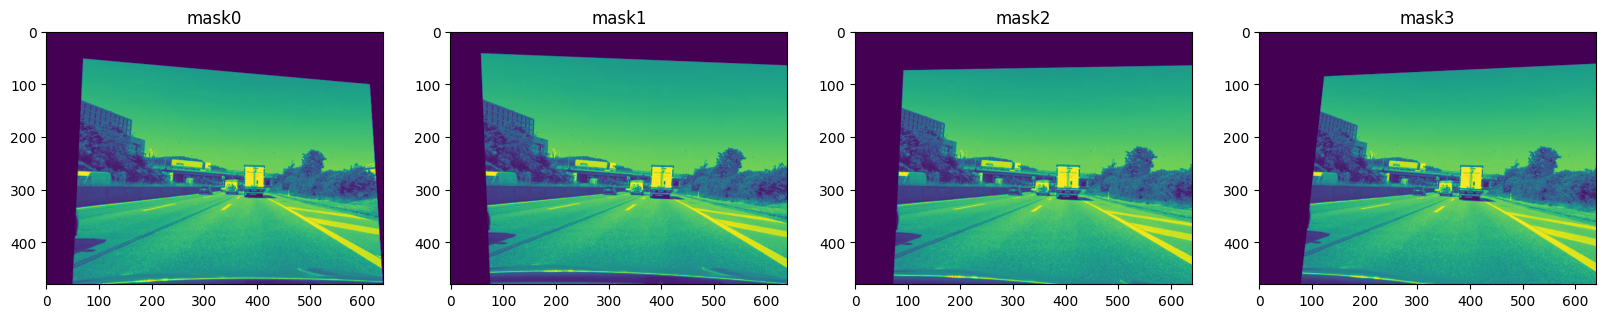

In [310]:
rec_best_gs_warped = [
    cv2.warpPerspective(ref_gs.copy(), H, (640, 480)) for H in res.values()
]
fig, axs = plt.subplots(1, len(rec_best_gs_warped), figsize=(20, 5))
for i, (ax, warped) in enumerate(zip(axs, rec_best_gs_warped)):
    mask = masks[f"mask{i}"]
    ax.imshow(warped)
    ax.set_title(list(res.keys())[i])
plt.show()

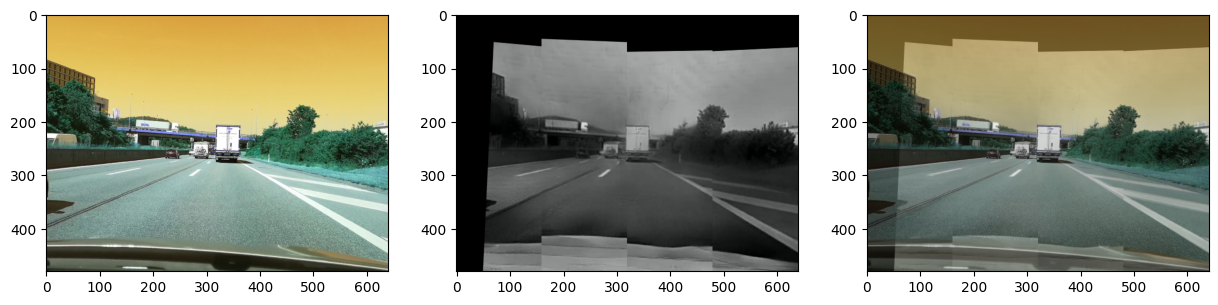

In [311]:
full = np.zeros_like(src_frames[0])
for name in res:
    mask = masks[name]
    h = res[name]
    rec_warped = cv2.warpPerspective(rec_frames[best_rec_idx], h, (640, 480))
    full[mask > 0] = rec_warped[mask > 0]

overlayed = cv2.addWeighted(full, 0.5, src_frames[ref_frame_idx], 0.5, 0)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(src_frames[ref_frame_idx])
axs[1].imshow(full)
axs[2].imshow(overlayed)
plt.show()

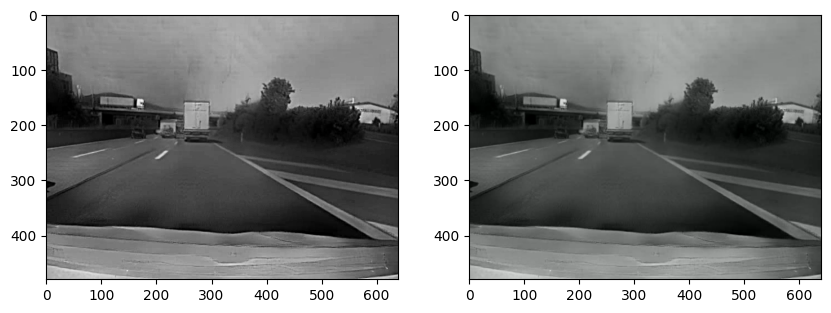

In [290]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(rec_best_gs, cmap="gray")
axs[1].imshow(rec_frames[best_rec_idx], cmap="gray")